In [76]:
import numpy as np
import pandas as pd
from pathlib import Path
%matplotlib inline

import warnings
warnings.simplefilter(action='ignore', category=Warning)

# Return Forecasting: Time Series Analysis & Modelling with CAD-PHY Exchange rate data.
In this notebook, you will load historical Canadian Dollar-Yen exchange rate futures data and apply time series analysis and modeling to determine whether there is any predictable behavior.

In [77]:
# Currency pair exchange rates for CAD/JPY
cad_jpy_df = pd.read_csv(
    Path("cad_jpy.csv"), index_col="Date", infer_datetime_format=True, parse_dates=True
)
cad_jpy_df.head()

,Price,Open,High,Low
Date,,,,
1982-01-05,184.65,184.65,184.65,184.65
1982-01-06,185.06,185.06,185.06,185.06
1982-01-07,186.88,186.88,186.88,186.88
1982-01-08,186.58,186.58,186.58,186.58
1982-01-11,187.64,187.64,187.64,187.64


In [78]:
# Trim the dataset to begin on January 1st, 1990
cad_jpy_df = cad_jpy_df.loc["1990-01-01":, :]
cad_jpy_df.head()

,Price,Open,High,Low
Date,,,,
1990-01-02,126.37,126.31,126.37,126.31
1990-01-03,125.30,125.24,125.30,125.24
1990-01-04,123.46,123.41,123.46,123.41
1990-01-05,124.54,124.48,124.54,124.48
1990-01-08,124.27,124.21,124.27,124.21


# Initial Time-Series Plotting

 Start by plotting the "Settle" price. Do you see any patterns, long-term and/or short?

<AxesSubplot:xlabel='Date'>

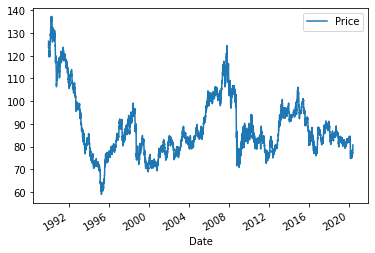

In [79]:
# Plot just the "Price" column from the dataframe:
# YOUR CODE HERE!
cad_jpy_df.plot(y="Price")

**Question:** Do you see any patterns, long-term and/or short? 

**Answer:** Long term price is heading lower, short term it is volatile within a band

---

# Decomposition Using a Hodrick-Prescott Filter

 Using a Hodrick-Prescott Filter, decompose the exchange rate price into trend and noise.

In [80]:
import statsmodels.api as sm

# Apply the Hodrick-Prescott Filter by decomposing the exchange rate price into two separate series:
# YOUR CODE HERE!
ts_noise, ts_trend = sm.tsa.filters.hpfilter(cad_jpy_df["Price"])

In [81]:
# Create a dataframe of just the exchange rate price, and add columns for "noise" and "trend" series from above:
# YOUR CODE HERE!
df_price=cad_jpy_df[["Price"]]
ts_noise=ts_noise.to_frame()
ts_trend=ts_trend.to_frame()

df_combined=pd.concat([df_price,ts_noise,ts_trend],axis=1,join="inner")
df_combined.head()

,Price,Price_cycle,Price_trend
Date,,,
1990-01-02,126.37,0.519095,125.850905
1990-01-03,125.30,-0.379684,125.679684
1990-01-04,123.46,-2.048788,125.508788
1990-01-05,124.54,-0.798304,125.338304
1990-01-08,124.27,-0.897037,125.167037


<AxesSubplot:xlabel='Date'>

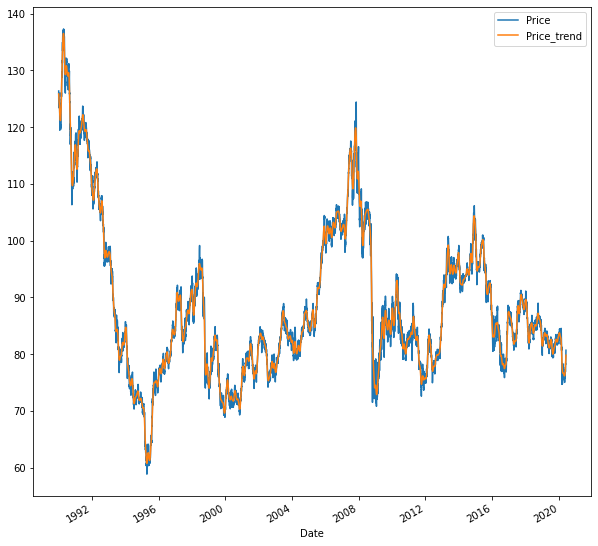

In [82]:
# Plot the Exchange Rate Price vs. the Trend for 2015 to the present
# YOUR CODE HERE!
df_combined.plot(y=["Price","Price_trend"],figsize=(10,10))

**Question:** Do you see any patterns, long-term and/or short?

**Answer:** Long term price is heading lower, short term it is volatile within a band

<AxesSubplot:xlabel='Date'>

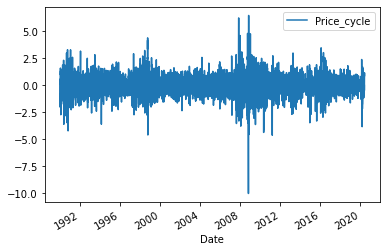

In [83]:
# Plot the Settle Noise
# YOUR CODE HERE!
df_combined.plot(y="Price_cycle")

---

# Forecasting Returns using an ARMA Model

Using exchange rate *Returns*, estimate an ARMA model

1. ARMA: Create an ARMA model and fit it to the returns data. Note: Set the AR and MA ("p" and "q") parameters to p=2 and q=1: order=(2, 1).
2. Output the ARMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
3. Plot the 5-day forecast of the forecasted returns (the results forecast from ARMA model)

In [84]:
# Create a series using "Price" percentage returns, drop any nan"s, and check the results:
# (Make sure to multiply the pct_change() results by 100)
# In this case, you may have to replace inf, -inf values with np.nan"s
returns = (cad_jpy_df[["Price"]].pct_change() * 100)
returns = returns.replace(-np.inf, np.nan).dropna()
returns.tail()

,Price
Date,
2020-05-29,0.076697
2020-06-01,1.251756
2020-06-02,1.425508
2020-06-03,0.373134
2020-06-04,0.012392


In [85]:
from statsmodels.tsa.arima_model import ARMA

# Estimate and ARMA model using statsmodels (use order=(2, 1))
# YOUR CODE HERE!
model = ARMA(cad_jpy_df["Price"], order=(1,1))

# Fit the model and assign it to a variable called results
# YOUR CODE HERE!
results = model.fit()

In [86]:
# Output model summary results:
# YOUR CODE HERE!
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                  Price   No. Observations:                 7929
Model:                     ARMA(1, 1)   Log Likelihood               -8750.412
Method:                       css-mle   S.D. of innovations              0.729
Date:                Wed, 23 Jun 2021   AIC                          17508.825
Time:                        19:45:16   BIC                          17536.738
Sample:                             0   HQIC                         17518.383
                                                                              
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          91.3468      6.963     13.119      0.000      77.700     104.994
ar.L1.Price     0.9990      0.001   1821.211      0.000       0.998       1.000
ma.L1.Price    -0.0273      0.011     -2.444      0.015      -0.049      -0.005
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0010           +0.0000j            1.0010            0.0000
MA.1           36.6131           +0.0000j           36.6131            0.0000
-----------------------------------------------------------------------------
"""

<AxesSubplot:title={'center':'Forecast'}>

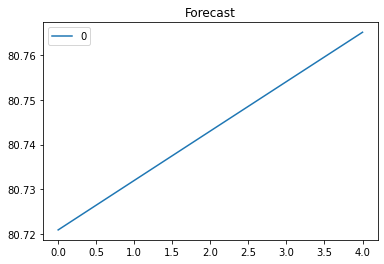

In [87]:
# Plot the 5 Day Returns Forecast
# YOUR CODE HERE!
pd.DataFrame(results.forecast(steps=5)[0]).plot(title="Forecast")

**Question:** Based on the p-value, is the model a good fit?

**Answer:** Yes as it is less than 5%

---

# Forecasting the Exchange Rate Price using an ARIMA Model

 1. Using the *raw* CAD/JPY exchange rate price, estimate an ARIMA model.
     1. Set P=5, D=1, and Q=1 in the model (e.g., ARIMA(df, order=(5,1,1))
     2. P= # of Auto-Regressive Lags, D= # of Differences (this is usually =1), Q= # of Moving Average Lags
 2. Output the ARIMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
 3. Plot a 5 day forecast for the Exchange Rate Price. What does the model forecast predict will happen to the Japanese Yen in the near term?

In [88]:
from statsmodels.tsa.arima_model import ARIMA

# Estimate and ARIMA Model:
# Hint: ARIMA(df, order=(p, d, q))
# YOUR CODE HERE!
model = ARIMA(cad_jpy_df["Price"], order=(2, 1, 2))
# Fit the model
# YOUR CODE HERE!
results = model.fit()

In [89]:
# Output model summary results:
# YOUR CODE HERE!
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.Price   No. Observations:                 7928
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -8746.734
Method:                       css-mle   S.D. of innovations              0.729
Date:                Wed, 23 Jun 2021   AIC                          17505.468
Time:                        19:45:19   BIC                          17547.336
Sample:                             1   HQIC                         17519.805
                                                                              
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0058      0.008     -0.733      0.464      -0.021       0.010
ar.L1.D.Price    -0.1663      0.482     -0.345      0.730      -1.111       0.778
ar.L2.D.Price     0.5004      0.309      1.621      0.105      -0.105       1.105
ma.L1.D.Price     0.1400      0.480      0.292      0.771      -0.801       1.081
ma.L2.D.Price    -0.5014      0.299     -1.677      0.094      -1.087       0.085
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.2572           +0.0000j            1.2572            0.5000
AR.2            1.5896           +0.0000j            1.5896            0.0000
MA.1           -1.2796           +0.0000j            1.2796            0.5000
MA.2            1.5588           +0.0000j            1.5588            0.0000
-----------------------------------------------------------------------------
"""

<AxesSubplot:title={'center':'Forecast'}>

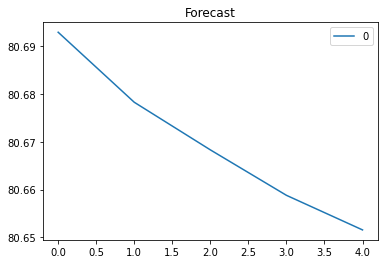

In [90]:
# Plot the 5 Day Price Forecast
# YOUR CODE HERE!
pd.DataFrame(results.forecast(steps=5)[0]).plot(title="Forecast")

**Question:** What does the model forecast will happen to the Japanese Yen in the near term?

**Answer:** Yen will become stronger

---

# Volatility Forecasting with GARCH

Rather than predicting returns, let's forecast near-term **volatility** of Japanese Yen exchange rate returns. Being able to accurately predict volatility will be extremely useful if we want to trade in derivatives or quantify our maximum loss.
 
Using exchange rate *Returns*, estimate a GARCH model. **Hint:** You can reuse the `returns` variable from the ARMA model section.

1. GARCH: Create an GARCH model and fit it to the returns data. Note: Set the parameters to p=2 and q=1: order=(2, 1).
2. Output the GARCH summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
3. Plot the 5-day forecast of the volatility.

In [91]:
from arch import arch_model

In [92]:
# Estimate a GARCH model:
# YOUR CODE HERE!
returns=cad_jpy_df.Price.pct_change().dropna()
model = arch_model(returns, mean="Zero", vol="GARCH", p=2, q=1)

# Fit the model
# YOUR CODE HERE!
res = model.fit(disp="off")

In [93]:
# Summarize the model results
# YOUR CODE HERE!
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - GARCH Model Results                        
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                27566.5
Distribution:                  Normal   AIC:                          -55125.1
Method:            Maximum Likelihood   BIC:                          -55097.2
                                        No. Observations:                 7928
Date:                Wed, Jun 23 2021   Df Residuals:                     7928
Time:                        19:45:20   Df Model:                            0
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      1.3722e-06  3.052e-11  4.496e+04      0.000 [1.372e-06,1.372e-06]
alpha[1]       0.0500  1.505e-02      3.323  8.920e-04 [2.051e-02,7.949e-02]
alpha[2]       0.0500  7.748e-03      6.453  1.097e-10 [3.481e-02,6.519e-02]
beta[1]        0.8800  6.841e-03    128.637      0.000     [  0.867,  0.893]
============================================================================

Covariance estimator: robust
"""

**Note:** Our p-values for GARCH and volatility forecasts tend to be much lower than our ARMA/ARIMA return and price forecasts. In particular, here we have all p-values of less than 0.05, except for alpha(2), indicating overall a much better model performance. In practice, in financial markets, it's easier to forecast volatility than it is to forecast returns or prices. (After all, if we could very easily predict returns, we'd all be rich!)

In [94]:
# Find the last day of the dataset
last_day = returns.index.max().strftime('%Y-%m-%d')
last_day

'2020-06-04'

In [95]:
# Create a 5 day forecast of volatility
forecast_horizon = 5

# Start the forecast using the last_day calculated above
# YOUR CODE HERE!
forecasts = res.forecast(start=last_day, horizon=forecast_horizon)

In [96]:
# Annualize the forecast
intermediate = np.sqrt(forecasts.variance.dropna() * 252)
intermediate.head()

,h.1,h.2,h.3,h.4,h.5
Date,,,,,
2020-06-04,0.126269,0.123181,0.123509,0.123657,0.123812


In [97]:
# Transpose the forecast so that it is easier to plot
final = intermediate.dropna().T
final.head()

Date,2020-06-04
h.1,0.126269
h.2,0.123181
h.3,0.123509
h.4,0.123657
h.5,0.123812


<AxesSubplot:>

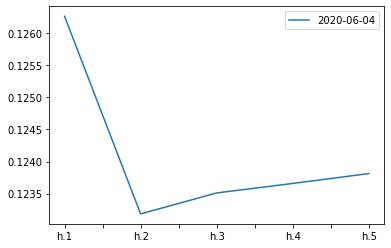

In [99]:
# Plot the final forecast
# YOUR CODE HERE!
final.plot(y="2020-06-04")

**Question:** What does the model forecast will happen to volatility in the near term?

**Answer:** Volatility falls

---

# Conclusions

1. Based on your time series analysis, would you buy the yen now?

    * Ybuy

2. Is the risk of the yen expected to increase or decrease?
    * decrease

3. Based on the model evaluation, would you feel confident in using these models for trading?
    * No